### Taken from https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn/notebook

### Dataset downloaded from https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist?resource=download-directory

### Downloaded zip file: Extract. Then files from 01,02,03,04,05 folders are used.

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
import keras
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import EarlyStopping
# Set paths to input and output data
INPUT_DIR = 'Audio_MNIST_data'
OUTPUT_DIR = 'Audio_MNIST_data_formatted'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in range(5):
    print(parent_list[i])

0_01_1.wav
0_01_10.wav
0_01_11.wav
0_01_12.wav
0_01_13.wav


## Plotting some audio files

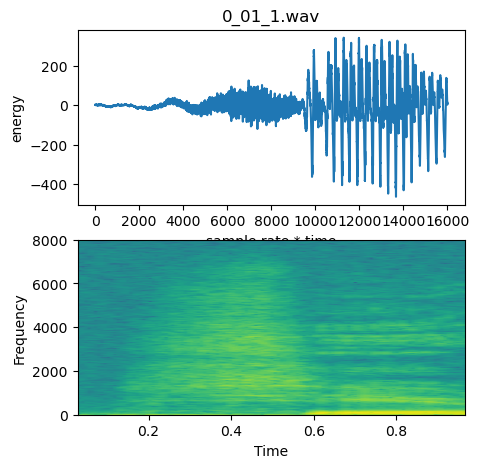

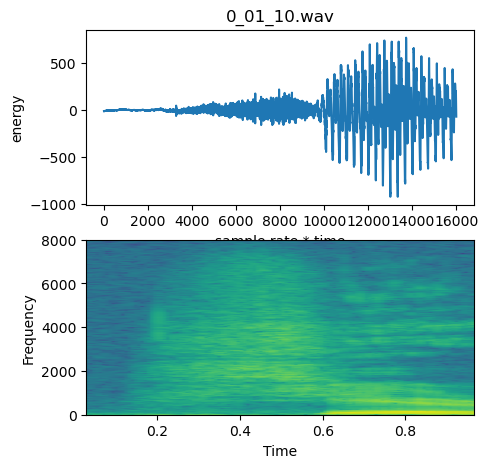

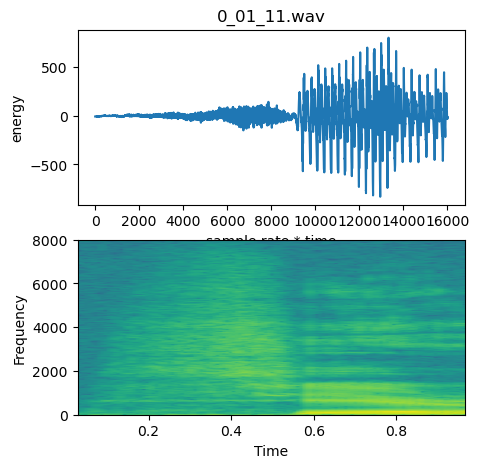

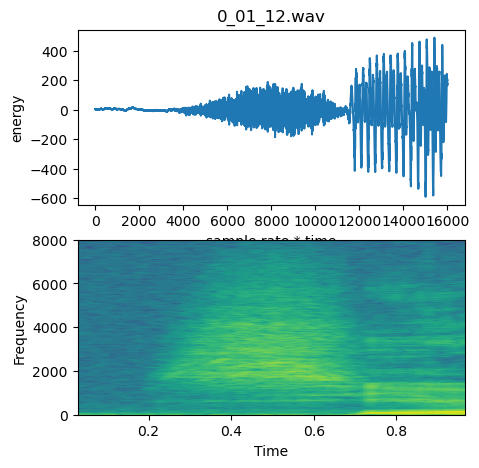

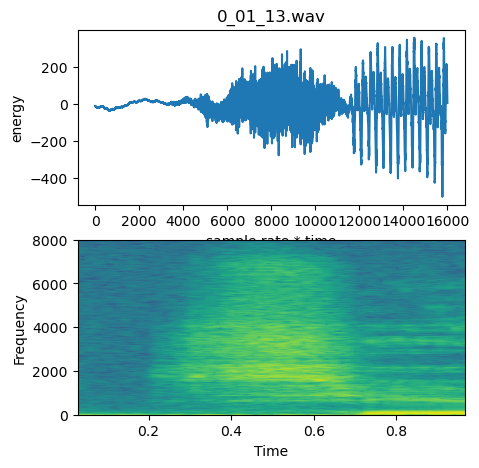

In [5]:
for i in range(5): 
    signal_wave = wave.open(INPUT_DIR+'/'+parent_list[i], 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(5,5))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

## Utility function to get sound and frame rate info. (Don't run again)

In [8]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    
for filename in os.listdir(INPUT_DIR):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIR, filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(10):
    print(path_list[i])
    
# File names for class 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

Classes: 

class_0
class_1
class_2
class_3
class_4
class_5
class_6
class_7
class_8
class_9

A few example files: 

1_01_0.png
1_01_1.png
1_01_10.png
1_01_11.png
1_01_12.png
1_01_13.png
1_01_14.png
1_01_15.png
1_01_16.png
1_01_17.png


## Preparing datasets for training and validation (Next time, start from here. Skip previous cell run)

In [9]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 2499 files belonging to 10 classes.
Using 2000 files for training.
Found 2499 files belonging to 10 classes.
Using 499 files for validation.


## Function to prepare our datasets for modelling.

In [10]:
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## 1. Build a classifier and training.

In [21]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.batches = []
        self.weight_save = []
        self.model_weights = model.get_weights()
        self.weight_masks = []
        for i in range(len(self.model_weights)):
            if i%2 == 0:
                self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.weight_masks.append(self.random_mask)
        for i in range(len(self.model_weights)):
            if i %2 == 0:
                self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
        model.set_weights(self.model_weights)
        self.weight_save.append(model.get_weights)       

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.batches.append(batch)
        self.model_weights = model.get_weights()
        for i in range(len(self.model_weights)):
            if i %2 == 0:
                self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
        model.set_weights(self.model_weights)
        self.weight_save.append(model.get_weights) 
       
                
l_history=LossHistory()

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=3, validation_data=valid_dataset, verbose = 1, callbacks = [es, l_history])

Epoch 1/3
63/63 [==============================] - 61s 942ms/step - loss: 2.3030 - accuracy: 0.0775 - val_loss: 2.3030 - val_accuracy: 0.0882
Epoch 2/3
63/63 [==============================] - 66s 1s/step - loss: 2.3028 - accuracy: 0.0905 - val_loss: 2.3034 - val_accuracy: 0.0902
Epoch 3/3
63/63 [==============================] - 66s 1s/step - loss: 2.3028 - accuracy: 0.0980 - val_loss: 2.3037 - val_accuracy: 0.0882


#### Ploting the model performance.

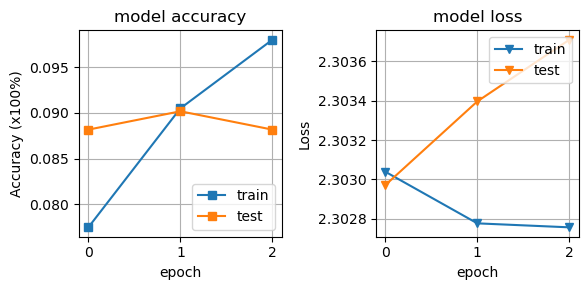

In [22]:
# plotting the metrics
fig = plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], marker = 's')
plt.plot(history.history['val_accuracy'], marker = 's')
plt.title('model accuracy')
plt.ylabel('Accuracy (x100%)')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], marker = 'v')
plt.plot(history.history['val_loss'], marker = 'v')
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()


In [23]:
len(l_history.weight_masks)

19

#### Sparsity percentage vs accuracy

In [24]:
#Sparsity percentage in each layer
for i in range(len(l_history.weight_masks)):
    print(f'sparsity in {i+1}th layer measured from mask:', 1-(np.count_nonzero(l_history.weight_masks[i])+0.0)/l_history.weight_masks[i].size)
    
print("---------------------------------------------------------------")    
for i in range(len(model.get_weights())):
    if i%2==0:
        print(f'Verification, sparsity in {i}th array from model.get_weights():',1-(np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)

sparsity in 1th layer measured from mask: 0.9710648148148148
sparsity in 2th layer measured from mask: 1.0
sparsity in 3th layer measured from mask: 0.96875
sparsity in 4th layer measured from mask: 0.9375
sparsity in 5th layer measured from mask: 0.96875
sparsity in 6th layer measured from mask: 0.96923828125
sparsity in 7th layer measured from mask: 0.953125
sparsity in 8th layer measured from mask: 0.984375
sparsity in 9th layer measured from mask: 1.0
sparsity in 10th layer measured from mask: 0.984375
sparsity in 11th layer measured from mask: 0.9690348307291666
sparsity in 12th layer measured from mask: 0.953125
sparsity in 13th layer measured from mask: 0.96875
sparsity in 14th layer measured from mask: 0.96875
sparsity in 15th layer measured from mask: 0.984375
sparsity in 16th layer measured from mask: 0.9688079357147217
sparsity in 17th layer measured from mask: 0.95703125
sparsity in 18th layer measured from mask: 0.97265625
sparsity in 19th layer measured from mask: 0.97343

#### Evaluating model performance

In [26]:
loss_and_metrics = model.evaluate(valid_dataset, verbose=2)

print("Test Loss {}.".format(loss_and_metrics[0]))
print("Test Accuracy {}%".format(loss_and_metrics[1]*100))

16/16 - 3s - loss: 2.3037 - accuracy: 0.0882 - 3s/epoch - 184ms/step
Test Loss 2.3037109375.
Test Accuracy 8.817635476589203%


## 2. Experimentation: Different sparsity and model performance measurement

In [28]:
#Sweeping the sparsity and measuring the model accuracy

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# compiling the sequential model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model_losses = []
model_accs = []
layerwise_sparsity = []
Layerwise_sparsity = []
model_sparsity = []
for sparsity in range(10):
    print('Model training for sparsity # {0}'.format(sparsity+1))
    class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if i%2 == 0:
                    self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                    for j in range(sparsity):
                        self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)       

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 

    l_history=LossHistory()
    history = model.fit(train_dataset, epochs=3, batch_size=128, validation_data=valid_dataset, verbose = 1, callbacks = [es, l_history])

    loss_and_metrics = model.evaluate(valid_dataset, verbose=2)
    model_losses.append(loss_and_metrics[0])
    model_accs.append(loss_and_metrics[1])
    
    for i in range(len(model.get_weights())):
        if i%2==0:
            layerwise_sparsity.append(1 - (np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)
    model_sparsity.append(np.mean(layerwise_sparsity))
    Layerwise_sparsity.append(layerwise_sparsity)
    layerwise_sparsity = []


Model training for sparsity # 1
Epoch 1/3
63/63 [==============================] - 62s 957ms/step - loss: 1.7699 - accuracy: 0.5550 - val_loss: 2.3068 - val_accuracy: 0.0982
Epoch 2/3
63/63 [==============================] - 74s 1s/step - loss: 1.3214 - accuracy: 0.7765 - val_loss: 2.3367 - val_accuracy: 0.0982
Epoch 3/3
63/63 [==============================] - 66s 1s/step - loss: 1.0726 - accuracy: 0.8235 - val_loss: 2.4652 - val_accuracy: 0.0982
16/16 - 3s - loss: 2.4652 - accuracy: 0.0982 - 3s/epoch - 214ms/step
Model training for sparsity # 2
Epoch 1/3
63/63 [==============================] - 67s 1s/step - loss: 2.3029 - accuracy: 0.1015 - val_loss: 2.3052 - val_accuracy: 0.0902
Epoch 2/3
63/63 [==============================] - 72s 1s/step - loss: 2.3027 - accuracy: 0.0970 - val_loss: 2.3055 - val_accuracy: 0.0902
Epoch 3/3
63/63 [==============================] - 73s 1s/step - loss: 2.3023 - accuracy: 0.1030 - val_loss: 2.3056 - val_accuracy: 0.0882
16/16 - 3s - loss: 2.3056 - ac

In [29]:
for (i,j,k) in zip(model_sparsity,model_accs,model_losses):
    print(f'sparsity = {round(i,5)}, Test accuracy = {round(j,5)}, Test loss = {round(k,5)}')

sparsity = 0.75599, Test accuracy = 0.0982, Test loss = 2.46518
sparsity = 0.90602, Test accuracy = 0.08818, Test loss = 2.30561
sparsity = 0.97455, Test accuracy = 0.08016, Test loss = 2.30537
sparsity = 0.99046, Test accuracy = 0.08016, Test loss = 2.30545
sparsity = 0.99597, Test accuracy = 0.08016, Test loss = 2.30567
sparsity = 0.99856, Test accuracy = 0.08016, Test loss = 2.30582
sparsity = 0.99881, Test accuracy = 0.08016, Test loss = 2.30587
sparsity = 0.99823, Test accuracy = 0.08016, Test loss = 2.30598
sparsity = 0.99998, Test accuracy = 0.08016, Test loss = 2.30614
sparsity = 0.99996, Test accuracy = 0.08016, Test loss = 2.3061


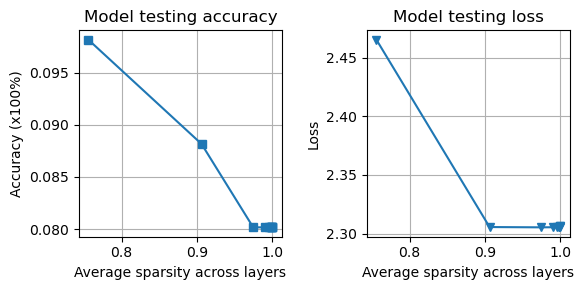

In [30]:
# plotting the metrics
fig = plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plt.plot(model_sparsity, model_accs, marker = 's')
plt.title('Model testing accuracy')
plt.grid()
plt.ylabel('Accuracy (x100%)')
plt.xlabel('Average sparsity across layers')

plt.subplot(1,2,2)
plt.plot(model_sparsity, model_losses, marker = 'v')
plt.title('Model testing loss')
plt.ylabel('Loss')
plt.xlabel('Average sparsity across layers')
plt.grid()
plt.tight_layout()